In [1]:
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import zipfile
import io
import matplotlib.pyplot as plt
import imageio
import pandas as pd
import os

from sklearn.linear_model import LogisticRegression
from sklearn import svm

%matplotlib inline


## 1. Region Proposal

In [2]:
def propose_regions(image, patch_dim=12):
    all_regions = []
    region_pos = []
    for i in range(image.shape[0]-patch_dim):
        for j in range(image.shape[0]-patch_dim):
            patch = image[i:(i+patch_dim), j:(j+patch_dim), :]
            all_regions.append(patch)
            region_pos.append((i, j))
    return region_pos, all_regions

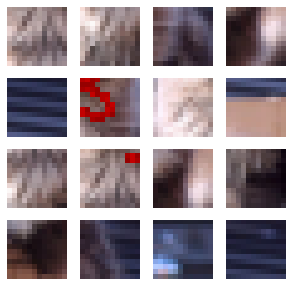

In [3]:
sample_img = imageio.imread("/classes/ece5470/lab/lab9/lab9data3r/im57.png")
region_pos, all_regions = propose_regions(sample_img)

sample_indices = np.random.randint(len(all_regions), size=16)

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i in range(len(sample_indices)):
    row = i // 4
    col = i % 4
    axes[row][col].imshow(all_regions[sample_indices[i]])
    axes[row][col].axis("off")

## 2. Feature Extractor

In [4]:
class ConvFeatureExtrator(nn.Module):
    def __init__(self):
        super(ConvFeatureExtrator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1)
            )
        self.fc1 = nn.Linear(8*8*16, 512)
        self.activation = F.relu
        # the last FC layer exists the pretrained classifer
        # for classifying if a 12x12 RGB patch contains a digit.
        # The FC layer is removed in the feature extrator since
        # we only want the encoding output from the convolutional
        # layer as input features of a digit classifier
        
        # self.fc2 = nn.Linear(256, 1) 
        
    def forward(self, x):
        out = self.conv(x)
        out = self.activation(out)
        out = out.reshape(out.size(0), -1)
        encoding = self.fc1(out)
        # out = self.f2(encoding) # removed from the classfier
        return encoding

In [5]:
feat_extractor = ConvFeatureExtrator()

# load state_dict for the feature extractor
pretrained_classifier_state_dict = torch.load("best_feature_extractor.pth")
feat_extractor.load_state_dict(pretrained_classifier_state_dict, strict=False)

# check output dimension of the feature extractor
feat_extractor.eval()
with torch.no_grad():
    sample_input = torch.unsqueeze(torch.FloatTensor(np.moveaxis(all_regions[42], -1, 0) / 255.0), axis=0)
    print("Feature extractor's input shape", sample_input.size())
    sample_encoding = feat_extractor(sample_input)
    print("Feature extractor's output shape =", sample_encoding.shape)

Feature extractor's input shape torch.Size([1, 3, 12, 12])
Feature extractor's output shape = torch.Size([1, 512])


## 3. Object classification

In [6]:
X = np.load("X_for_object_classification.npy")
y = np.load("y_for_object_classification.npy")

X_train = X[:1700, :]
y_train = y[:1700]

print("Input shape =", X_train.shape)
print("Target shape =", y_train.shape)

Input shape = (1700, 512)
Target shape = (1700,)


In [7]:
BACKGROUND_LABEL = 10
NUM_FOREGROUND_LABELS = 10

# train a binary classifier for each digit
classifiers = []

for digit_label in range(NUM_FOREGROUND_LABELS):
    pos_y_indices = list((y_train == digit_label).nonzero()[0])
    neg_y_indices = (y_train == BACKGROUND_LABEL).nonzero()[0]
    
    # match the number of positive (containing a digit) and negative examples (only background) for each digit
    sample_neg_y_indices = list(np.random.choice(neg_y_indices, size=len(pos_y_indices)))
    
    combined_indices = np.asarray(pos_y_indices+sample_neg_y_indices)
    np.random.shuffle(combined_indices)
    
    single_digit_X = X_train[combined_indices, :]
    single_digit_y = (y_train[combined_indices] == digit_label).astype(int)
    
    clf = LogisticRegression(random_state=42, C=1e5).fit(single_digit_X, single_digit_y)
    test_X = X[1700:, :]
    test_y = (y[1700:] == digit_label).astype(int)

    print("Score on test samples for digit", digit_label, "=", clf.score(test_X, test_y))
    classifiers.append(clf)

Score on test samples for digit 0 = 0.55
Score on test samples for digit 1 = 0.52
Score on test samples for digit 2 = 0.57
Score on test samples for digit 3 = 0.61
Score on test samples for digit 4 = 0.52
Score on test samples for digit 5 = 0.55
Score on test samples for digit 6 = 0.57
Score on test samples for digit 7 = 0.54
Score on test samples for digit 8 = 0.54
Score on test samples for digit 9 = 0.58


## RCNN - Putting everything together

In [8]:
img_dir = "/classes/ece5470/lab/lab9/lab9data3r"
labels_df = pd.read_csv(os.path.join(img_dir, "labels.csv"))
img_labels = labels_df.iloc[:, 0].values
targets = labels_df.iloc[:, 1].values

all_test_img_labels = img_labels[:100]
all_test_targets = targets[:100]

In [ ]:
all_pred_region_indices = []
all_pred_labels = []

acc = 0.0
with torch.no_grad():
    for i in range(len(all_test_targets)):
        if i % 10 == 0:
            print("sample", i+1, "/", len(all_test_targets))
        test_target = all_test_targets[i]
        img_label = all_test_img_labels[i]
        img_id = img_label.split(".")[0][2:]

        input_img_label = "im%s.png" % img_id
        input_img_path = os.path.join(img_dir, input_img_label)

        input_img = np.asarray(imageio.imread(input_img_path))
        input_img = input_img / 255.0

        region_pos, all_regions = propose_regions(input_img)
        all_region_feats = []
        all_region_digit_probs = np.zeros((len(all_regions), NUM_FOREGROUND_LABELS))
        for j in range(len(all_regions)):
            region = torch.FloatTensor(np.expand_dims(np.moveaxis(all_regions[j], -1, 0), axis=0))
            feat = feat_extractor(region).squeeze().numpy()
            all_region_feats.append(feat)
        
        all_region_feats = np.asarray(all_region_feats)

        for k in range(len(classifiers)):
            classifier = classifiers[k]
            probs = classifier.predict_proba(all_region_feats)
            all_region_digit_probs[:, k] = probs[:, 1]

        max_loc = np.where(all_region_digit_probs == np.max(all_region_digit_probs))
        pred_region_idx = max_loc[0].item()
        pred_label = max_loc[1].item()
        
        all_pred_region_indices.append(pred_region_idx)
        all_pred_labels.append(pred_label)
        acc = acc + (pred_label == test_target) / len(all_test_targets)
    
    

sample 1 / 100
sample 11 / 100
sample 21 / 100
sample 31 / 100
sample 41 / 100
sample 51 / 100
sample 61 / 100


In [ ]:
print("Object classification accuracy = %.2f" % (acc * 100))

In [ ]:
def visualize_pred(img, true_label, pred_region_pos, pred_label, patch_dim=12, boundary_color=[255, 255, 255]):
    x, y = pred_region_pos
    img[x, y:(y+patch_dim), :] = boundary_color
    img[x:(x+patch_dim), y, :] = boundary_color
    img[(x+patch_dim), y:(y+patch_dim), :] = boundary_color
    img[x:(x+patch_dim), y+patch_dim, :] = boundary_color
    
    plt.imshow(img)
    plt.title("True label = %d; Pred = %d" % (true_label, pred_label))

In [ ]:
sample_index = np.random.choice(len(all_test_targets))
pred_label = all_pred_labels[sample_index]
sample_target = all_test_targets[sample_index]

sample_img_label = all_test_img_labels[sample_index]
img_id = sample_img_label.split(".")[0][2:]

sample_img_label = "im%s.png" % img_id
sample_img_path = os.path.join(img_dir, sample_img_label)

sample_img = imageio.imread(sample_img_path)

all_region_pos, all_regions = propose_regions(input_img)
region_pos = all_region_pos[all_pred_region_indices[sample_index]]

visualize_pred(sample_img, sample_target, region_pos, pred_label)
